# 1. Data collection
Sound of cars and trams are partly recorded and used during the trainingm and parts of them are from the Internet.

For the recorded sounds:
- source: trams and cars passing in Hervanta
- what: the sound of trams arriving to the platform and cars passing
- where: around Hervanta, particularly Opiskelija tram platform
- method: a smartphone with audio recording software were used

For the online sourced sounds:
1. Tram
- source: [tram](https://freesound.org/people/ilknur_bas/packs/37103/)
- what: the sound of trams arriving to the platform and cars passing
- where: around Tampere, Kaleva
- method: an iPhone12 audio recording software were used
2. Car
- source: [car](https://freesound.org/people/trung1309vn/packs/39612/)
- what: the sound of cars A passing by from distance
- where: Hervannan valtaväylä road, Tampere
- method: a Redmi 9C audio recording software were used

In [1]:
import librosa as lb
import sounddevice as sd
import soundfile as sf
data, sr = lb.load('data/tram/tram1.wav', sr=None)
sd.play(data)

# 2. Feature extraction
Online-downloaded audio are in .wav format

For self-recorded sounds, the method used for .wav conversion were:
- the recorded sounds were in the format .m4a
- using librosa with ffmpeg package from [chocolatey](https://community.chocolatey.org/packages/ffmpeg) to read the .m4a file
- use the output data and sample rate to write to a new .wav file using [soundfile](https://pypi.org/project/soundfile/)

In [2]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x = 3
a[-x:]

[8, 9, 10]

In [118]:
import numpy as np
import os
import matplotlib.pyplot as plt

sr = 48000
length_expected = int(sr * 5)
data_folder = 'data/'
tram = []
car = []
for o in ['car', 'tram']:
    data_files = data_folder + o + '/'
    for name in os.listdir(data_files):
        path = os.path.join(data_files, name)
        if path.__contains__('.wav'):
            data, sr = lb.load(path, sr=None)
            # data cleansing
            mean = np.mean(data)
            std_dev = np.std(data)
            normalized_data = data # (data - mean) / std_dev

            length_data = len(normalized_data)
            if length_data > length_expected:
                remain = int(length_data - length_expected)
                if normalized_data[:remain].sum() > normalized_data[-remain:].sum():
                    normalized_data = normalized_data[:length_expected].copy()
                else:
                    normalized_data = normalized_data[-length_expected:].copy()

            elif length_data < length_expected:
                remain = int(length_expected - length_data)
                added_noise = np.zeros((remain,)) #np.random.normal(loc=mean, scale=std_dev, size=(remain,))
                normalized_data = np.concat([added_noise, normalized_data]).copy()
            if path.__contains__('tram'):
                tram.append(normalized_data)
            else:
                car.append(normalized_data)

tram = np.array(tram)
car = np.array(car)

print(tram.shape)
print(car.shape)


(30, 240000)
(27, 240000)


# 3. Define model

Simple binary classifier
1. Support Vector Machine (SVM)
2. Nearest Neighbour
3. Logistic Regression

Split data

In [119]:
import noisereduce as nr

# Combine dataset
x = np.vstack((tram, car))
x = nr.reduce_noise(x, sr)

# stft
period = 0.1
win_size = int(sr * period)
window = np.hamming(win_size)
nfft = win_size
hop_size = int(0.5 * win_size)

x_stft = np.abs(lb.stft(x, n_fft=nfft, win_length=win_size, hop_length=hop_size, window=window)).reshape((57,-1))
# x_stft = (x_stft - np.mean(x_stft,axis=1)) / np.std(x_stft,axis=1)
for i in range(len(x_stft)):
    x_stft[i,:] = (x_stft[i,:] - np.mean(x_stft[i,:])) / np.std(x_stft[i,:])

print(x_stft.shape)

(57, 242501)


In [120]:
# import class to define model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Define labels
y_tram = np.zeros(tram.shape[0]) # 27 zeros for tram
y_car = np.ones(car.shape[0]) # 30 ones for car
y = np.concatenate((y_tram, y_car))

x_train, x_test, y_train, y_test = train_test_split(x_stft, y, test_size = 0.2)



# 4. Train the model

How to evaluate the model:
- Accuracy: ratio of correctly predicted observation to the total observations.
- Precision: ratio of correctly predicted positive observations to the total predicted positive observations.
- Recall: ratio of correctly predicted positive observations to the all the observations of that class.

4


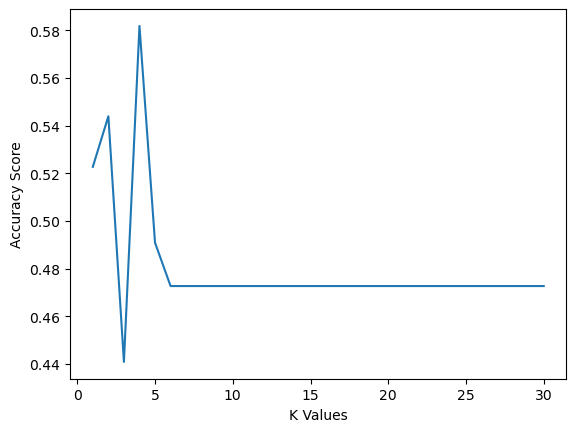

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
# import seaborn as sns

# Fitting and evaluating the model
# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(x_train, y_train)

# y_pred = knn.predict(x_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

# Using Cross Validation to Get the Best Value of k
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x, y, cv=5)
    scores.append(np.mean(score))

# sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.plot(k_values,scores)
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

best_index = np.argmax(scores)
best_k = k_values[best_index]
print(best_k)

In [128]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8333333333333334
Precision: 1.0
Recall: 0.7142857142857143
